In [37]:
import pandas as pd
import logging
import numpy as np
import re
import nltk
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [38]:
# logging instead of print
# write all of the levels a logger can have
logger_levels = [logging.DEBUG, logging.INFO, logging.WARNING, logging.ERROR, logging.CRITICAL]
# create console handler and set level to info
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# create logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# add ch to logger
logger.addHandler(ch)

# Load data from Kaggle
[Link to English Word Frequency Dataset](https://www.kaggle.com/datasets/rtatman/english-word-frequency) on Kaggle

In [39]:
english_words = pd.read_csv('data/english-words-freq.csv')
logger.info(english_words.head())

2023-03-27 13:26:30,771 - root - INFO -   word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698
2023-03-27 13:26:30,771 - root - INFO -   word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698
2023-03-27 13:26:30,771 - root - INFO -   word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698
2023-03-27 13:26:30,771 - root - INFO -   word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698
2023-03-27 13:26:30,771 - root - INFO -   word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698


# Load in Rap Lyrics data
This is the data set we scraped ourselves

In [40]:
rap_words = pd.read_csv('data/rap-words-freq.csv')
# rename the word column into index and index into word
rap_words = rap_words.rename(columns={'word': 'index', 'index': 'word'})
# drop the index column
rap_words = rap_words.drop(columns=['index'])
logger.info(rap_words.head())

2023-03-27 13:26:30,803 - root - INFO -      word  count  swearword
0     and   1978      False
1    they    912      False
2  wishin     30      False
3      on   1903      False
4      me   2294      False
2023-03-27 13:26:30,803 - root - INFO -      word  count  swearword
0     and   1978      False
1    they    912      False
2  wishin     30      False
3      on   1903      False
4      me   2294      False
2023-03-27 13:26:30,803 - root - INFO -      word  count  swearword
0     and   1978      False
1    they    912      False
2  wishin     30      False
3      on   1903      False
4      me   2294      False
2023-03-27 13:26:30,803 - root - INFO -      word  count  swearword
0     and   1978      False
1    they    912      False
2  wishin     30      False
3      on   1903      False
4      me   2294      False
2023-03-27 13:26:30,803 - root - INFO -      word  count  swearword
0     and   1978      False
1    they    912      False
2  wishin     30      False
3      on   1903

# Clean up the data and apply preprocessing

In [41]:
def preprocess(df, is_rap=False):
    if not is_rap:
        df['swearword'] = False

    # sum the count column
    N = df['count'].sum()
    df['freq'] = df['count'] / N
    return df

In [42]:
english_words = preprocess(english_words)
rap_words = preprocess(rap_words, is_rap=True)

# Exploratory Data Analysis
1. Create a plot showing the frequency of the top 10 most common words in the English language and how frequent they are in rap lyrics and vice versa

In [91]:
# 1.
def plot_top_n(n):
    # sort the english words by frequency and get the top 10
    english_top_n = english_words.sort_values(by='freq', ascending=False).head(n)
    rap_top_n = rap_words.sort_values(by='freq', ascending=False).head(n)
    # fetch the frequency of the top 10 words in the other case
    english_top_n = english_top_n.merge(rap_words[['word', 'count','freq']], on='word', suffixes=('', '_rap'))
    rap_top_n = rap_top_n.merge(english_words[['word', 'count','freq']], on='word', suffixes=('', '_english'))
    print('---ENGLISH---')
    print(english_top_n.head())
    print('---RAP---')
    print(rap_top_n.head())

    # use sns to create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 10))
    # plot a bar plot on ax1, not stacked, of freq and rap_freq
    english_top_n.plot.bar(x='word', y=['freq', 'freq_rap'], ax=ax1, stacked=False)
    # set the x axis label to 'Word'
    ax1.set_xlabel('Word')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.legend(['Frequency', 'Frequency Rap'])
    # format the y axis to be a percentage with 2 decimal places
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1%}".format(x)))
    ax1.set_title(f'English Top {n} Most Common Words, compared to Rap')
    # plot a bar plot on ax2, not stacked, of freq and english_freq
    rap_top_n.plot.bar(x='word', y=['freq', 'freq_english'], ax=ax2, stacked=False)
    ax2.set_xlabel('Word')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.legend(['Frequency', 'Frequency English'])
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1%}".format(x)))
    ax2.set_title(f'Rap Top {n} Most Common Words, compared to English')
    # set the title for the entire figure
    fig.suptitle(f'Comparison of Top {n} Most Common Words')
    plt.show()


---ENGLISH---
  word        count  swearword      freq  count_rap  freq_rap
0  the  23135851162      False  0.039338       4846  0.031165
1   of  13151942776      False  0.022363        700  0.004502
2  and  12997637966      False  0.022100       1978  0.012721
3   to  12136980858      False  0.020637       1927  0.012393
4    a   9081174698      False  0.015441       3240  0.020837
---RAP---
  word  count  swearword      freq  count_english  freq_english
0    i   5902      False  0.037956     3086225277      0.005248
1  the   4846      False  0.031165    23135851162      0.039338
2  you   3900      False  0.025081     2996181025      0.005094
3    a   3240      False  0.020837     9081174698      0.015441
4   my   2375      False  0.015274     1059793441      0.001802


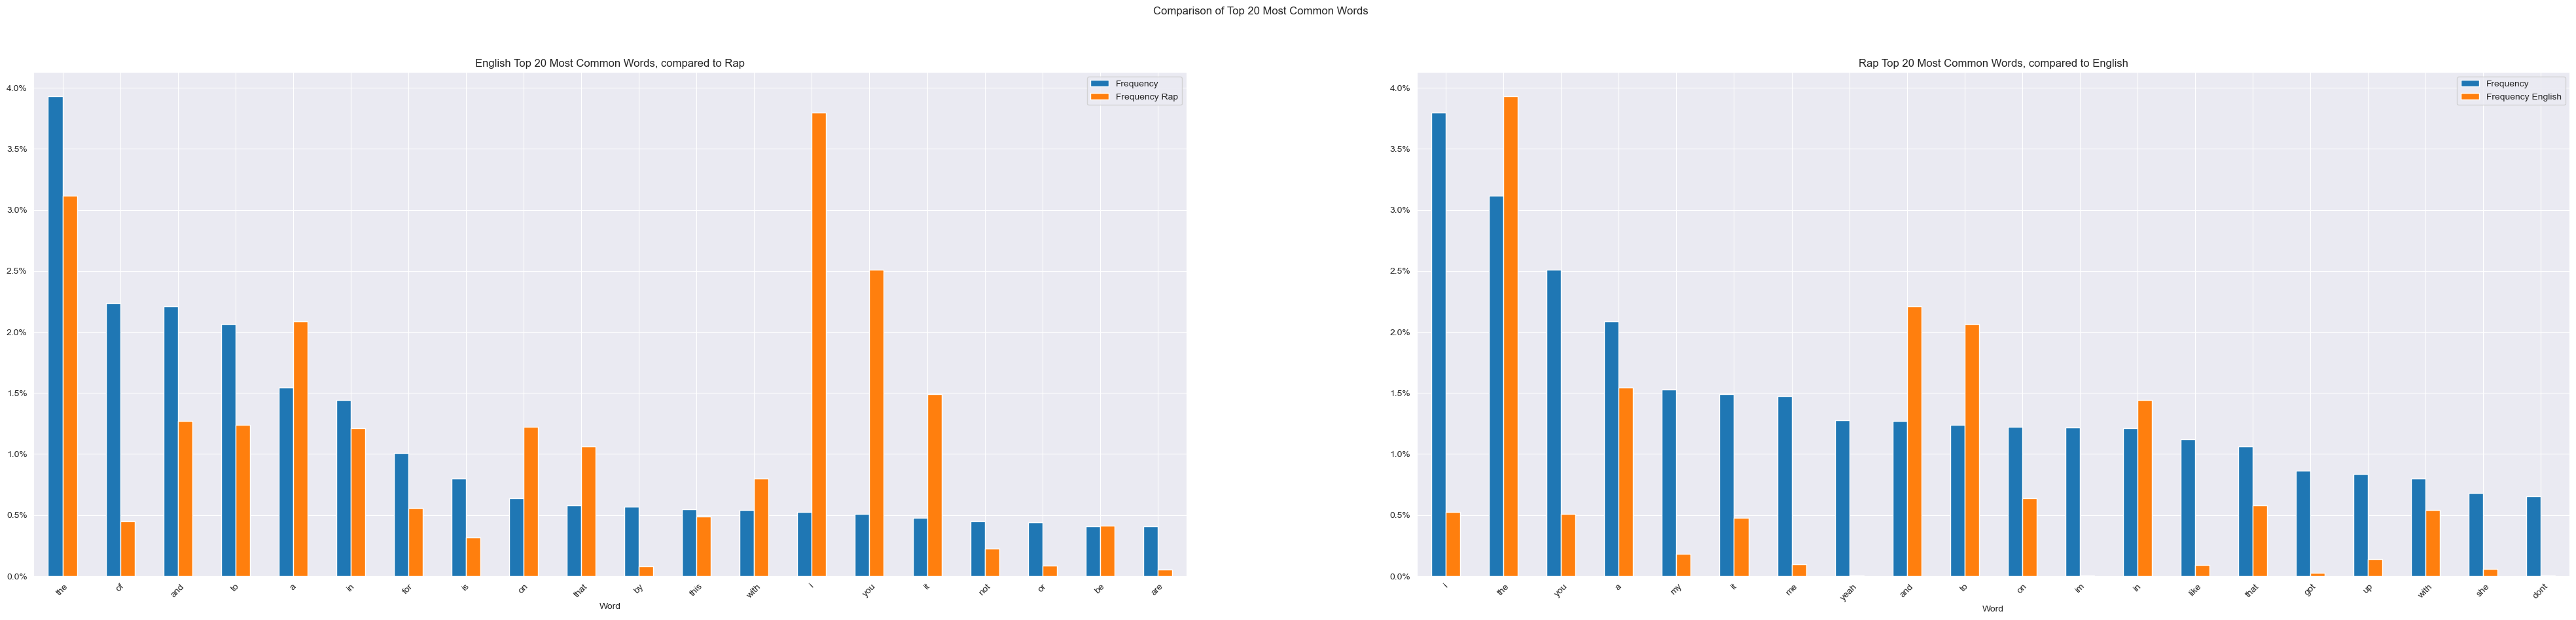

In [92]:
plot_top_n(20)